## <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'></span></b> <b>Model1 EffB0_10m_50s</b></div>

### <b><span style='color:#A51C30'> 1.1 </span> Initializing Accelerator</b> 

In [1]:
'''I'm gonna use GPU'''

# GPU T4x2: For AI & DeepLearning 
# GPU P100: For High Performacne Computing(HPC)

'''We're gonna build AI model'''

# cleaning memory
import gc
import ctypes

import os
import tensorflow as tf
# CUDA: 일종의 GPU 병렬 프로그래밍 
# CUDA GPU 2개를 지정
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
import tensorflow as tf 
print(f'tensorflow version', tf.__version__)

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# USE Multiple GPU 
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPUS')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUS')
    
VER = 2 # Starter Version

LOAD_MODELS_FROM = '/kaggle/input/labeled-wavenet/'

2024-03-21 04:28:42.655048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 04:28:42.655162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 04:28:42.829135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version 2.15.0
Using 2 GPUS


In [2]:
!pip install /kaggle/input/wheel-albumentation/albumentations-1.4.0-py3-none-any.whl

Processing /kaggle/input/wheel-albumentation/albumentations-1.4.0-py3-none-any.whl
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1


In [3]:
import keras
os.environ['KERAS_BACKEND'] = 'jax'
keras.utils.set_random_seed(42)

### USE MIXED PRECISION
- Not using: Full Precision
- Using: Mixed Precision

- `사용이유`: 계산을 보다 더 효율적으로 수행하기 위해서 

In [4]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


### Clean Memory

In [5]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [6]:
df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
TARGETS = df.columns[-6:] # series 형태로 반환됨
print('train shape', df.shape)
print('targets', list(TARGETS)) #list로 바꿈
display(df.head())

train shape (106800, 15)
targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


### <b><span style='color:#A51C30'> 2.1 </span> Non Overlapping EED ID Train Data</b> 

In [7]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

df['total_evaluators'] = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)
tmp = df.groupby('eeg_id')['total_evaluators'].agg('first')
train['total_evaluators'] = tmp

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 13)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_evaluators,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,12,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,14,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,1,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,1,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,2,Other


In [8]:
NAMES = ['LL','LP','RP','RR']


FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2'],]

In [9]:
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt, firwin

def total_filter(data, sampling_rate=200, order=2):
    # Normalization
    nyquist = 0.5 * sampling_rate
    # First Filtering: Notch Filtering[특정 주파수 제거]
    notch_freq = 60
    Q = 30
    notch_freq_normalized = notch_freq / nyquist
    # b, a = butter(order, [notch_freq_normalized], btype='bandstop')
    
    # filtered_data = filtfilt(b, a, data, axis=0)
    # Second Filtering: Band Pass Filtering[특정 주파수 강조] 
    # 강조할 주파수 대역: 0.5~20Hz 
    normal_lowest_cutoff = 0.5 / nyquist
    normal_highest_cutoff = 20 / nyquist
    num_taps = 100  # 필터의 길이, 적절한 값으로 조정해야 함
    b = firwin(num_taps, [normal_lowest_cutoff, normal_highest_cutoff], pass_zero=False)
    
    filtered_data = filtfilt(b, 1, data, axis=0)
    
    # Third Filtering: Guassian Pass[Image Smoothing]
    # Small Sigma: 저주파수 성분 보존, 고주파 잡음을 감소
    # Big Sigma: 더 작은 지역적인 특징 
    filtered_data = gaussian_filter(filtered_data, sigma=1, order=2, mode='reflect')
    return filtered_data

In [10]:
import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        if k < 4:
            for kk in range(4):
        
                # COMPUTE PAIR DIFFERENCES
                x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

                # FILL NANS
                m = np.nanmean(x)
                if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
                else: x[:] = 0

                total_filter(x)    
                    
                signals.append(x)

                # RAW SPECTROGRAM
                mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                     n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

                # LOG TRANSFORM
                width = (mel_spec.shape[1]//32)*32
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

                # STANDARDIZE TO -1 TO 1
                mel_spec_db = (mel_spec_db+40)/40 
                img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
            img[:,:,k] /= 4.0
            
            
        
        if display:
            plt.subplot(3,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

In [11]:
params = {    
    "num_masks_x": 1, 
    "mask_x_length": (10, 20),
    "fill_value": (4,5,6,7),  
}

In [12]:
import albumentations as albu
import cv2
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, augment1=False, augment2=False, augment3=False, mode='train',
                 specs = None, eeg_specs = None): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2= augment2
        self.augment3 = augment3
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment1: X = self.__mixup(X) 
        if self.augment2: X = self.__cutmix(X)
        if self.augment3: X = self.__augment_batch(X)
            
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        
        X = np.zeros((len(indexes),128,256,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        img = np.ones((128,256),dtype='float32')
        
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode=='test':  
                r = 0
            else: 
                r = int( (row['min'] + row['max'])//4 )

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300,k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img,np.exp(-4),np.exp(8)) # 이상치 제거 
                img = np.log(img)
                
                # STANDARDIZE -1~1
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img-m)/(s+ep) # null 값 방지 
                img = np.nan_to_num(img, nan=0.0) # fillnan
                
                # CROP TO 256 TIME STEPS
                X[j,14:-14,:,k] = img[:,22:-22] / 2.0
        
            # EEG SPECTROGRAMS 50S
            # 그전에 미리 log transform, standardize -1~1 진행함
            img = self.eeg_specs[row.eeg_id]
            X[j,:,:,4:] = img
            
            if self.mode!='test':
                y[j,] = row[TARGETS]
                
            
        return X,y
    
    def __cutmix(self, img_batch, cutmix_prob=0.25):
        batch_size, height, width, channels = img_batch.shape
    # 랜덤하게 인덱스 선택
        idx = np.random.permutation(batch_size)
        if np.random.rand() < cutmix_prob:  # cutmix_prob 확률로 cutmix을 수행할지 결정
            lam = np.random.beta(0.5, 0.5)  # Beta 분포를 사용하여 lambda 값을 샘플링
            mixed_batch = []
            for i in range(batch_size):
                j = idx[i]
                mixed_img = img_batch[i].copy()
                if channels >= 4:  # 이미지 채널이 4 이상일 때만 CutMix 수행
                    # Choose random position for cropping
                    crop_x = np.random.randint(0, width)
                    crop_y = np.random.randint(0, height)
                    crop_width = min(int(width * np.sqrt(1 - lam)), 50)
                    crop_height = min(int(height * np.sqrt(1 - lam)), 25)

                # Mix images using CutMix
                    mixed_img[crop_y:crop_y + crop_height, crop_x:crop_x + crop_width, 4:] = img_batch[j, crop_y:crop_y + crop_height, crop_x:crop_x + crop_width, 4:]
                mixed_batch.append(mixed_img)
            mixed_batch = np.array(mixed_batch)
            return mixed_batch
        else:
            return img_batch

        
    def __random_transform(self, img):
        composition = albu.Compose([
              albu.VerticalFlip(p=0.25)
         ])
        # 채널이 4 이상이면 XYMasking을 적용하도록 이미지의 채널을 조정
        if img.shape[2] >= 4:
            transformed_img = composition(image=img[:, :, :4])['image']
            img[:, :, :4] = transformed_img
        return img
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch    
    
    def __mixup(self, img_batch, mixup_prob=0.25):
        batch_size, height, width, channels = img_batch.shape
        # 랜덤하게 인덱스 선택
        idx = np.random.permutation(batch_size)
        if np.random.rand() < mixup_prob:  # mixup_prob 확률로 mixup을 수행할지 결정
            lam = np.random.beta(0.5, 0.5) # Beta 분포를 사용하여 lambda 값을 샘플링
            mixed_batch = []
            for i in range(batch_size):
                j = idx[i]
                mixed_img = lam * img_batch[i] + (1 - lam) * img_batch[j]
                mixed_batch.append(mixed_img)
            mixed_batch = np.array(mixed_batch)    
            return mixed_batch
        else:
            return img_batch

### <b><span style='color:#A51C30'> 4.2 </span> Build EfficientNet</b> 

In [13]:
!pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
Processing /kaggle/input/tf-efficientnet-whl-files/Keras_Applications-1.0.8-py3-none-any.whl (from efficientnet==1.1.1)


In [14]:
import efficientnet.tfkeras as efn

# 전체구조 설명 
# input -> kaggle&eeg 별 Concatenate -> Dense -> Softmax
def build_model():
    
    # Input(비어 있음)
    inp = tf.keras.Input(shape=(128,256,8))
    # BackBone
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)
    base_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    # Freezing Backbone Weight
    freeze_layers = 40
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False 
    
    # Kaggle Spectrogram 
    # 128 x 4 = 512, shape: 512 x 256
    x1 = [inp[:,:,:,k:k+1] for k in range(4)]
    x1 = tf.keras.layers.Concatenate(axis=1)(x1)    
    # EEG Spectrogram 50s
    # 128 X 4 = 512, shape: 512 X 256
    x2 = [inp[:,:,:,k+4:k+5] for k in range(4)]
    x2 = tf.keras.layers.Concatenate(axis=1)(x2)
    
    x = tf.keras.layers.Concatenate(axis=2)([x1,x2])
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])

    
    # Output
    x = base_model(x) 
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(6, activation='softmax', dtype='float32')(x)
    
    # Compile(loss: KL, optimizer: Adam)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)
    
    return model 

In [15]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [16]:
# READ ALL SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms2 = {}
for i,f in enumerate(files2):
    if i%100==0: print(i,', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:,1:].values

# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id':'spec_id'},axis=1)

There are 1 test spectrogram parquets
0 , 

Converting Test EEG to Spectrograms...



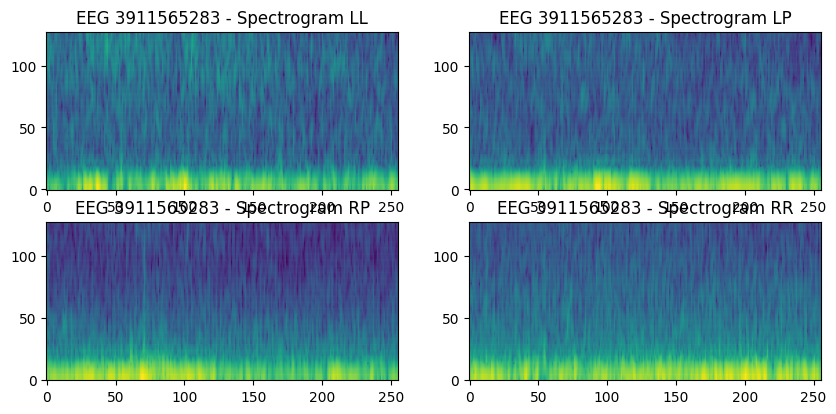

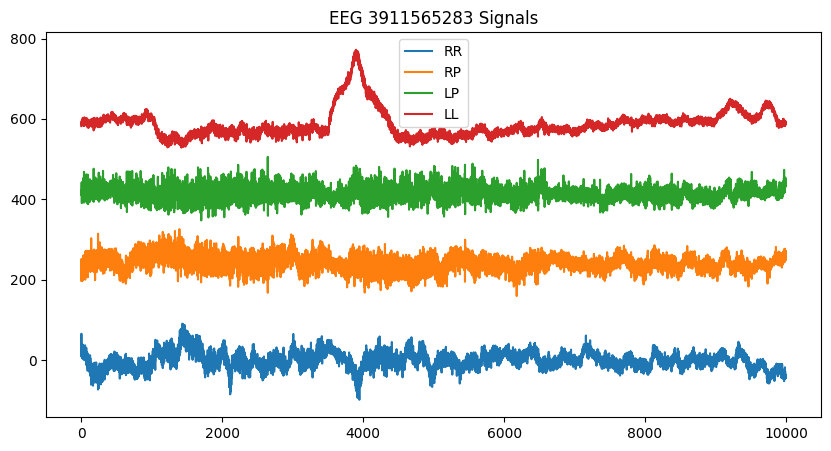


#########################



In [17]:
# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = img

In [18]:
preds = []
model = build_model()

# TTA: Test Time Argument
test_gen = DataGenerator(test, shuffle=False, batch_size=64, mode='test', augment3=True,
                         specs = spectrograms2, eeg_specs = all_eegs2) # HFlip 

for i in range(5):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'EffNet_v{VER}_f{i}.h5')
    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)    
    
    
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 4s 4s/step
Fold 2
1/1 [==============================] - 0s 48ms/step
Fold 3
1/1 [==============================] - 0s 47ms/step
Fold 4
1/1 [==============================] - 0s 49ms/step
Fold 5
1/1 [==============================] - 0s 46ms/step

Test preds shape (1, 6)


In [19]:
del all_eegs2, spectrograms2; gc.collect()

8475

## <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'></span></b> <b>Model2 ResNet2d Inference</b></div>

In [20]:
import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl

In [21]:
VER = 1 # Starter Version

LOAD_MODELS_FROM = '/kaggle/input/resnet34-eeg'

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

In [22]:
NAMES = ['LL','LP','RP','RR']


FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2'],]

In [23]:
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt, firwin

def total_filter(data, sampling_rate=200, order=2):
    # Normalization
    nyquist = 0.5 * sampling_rate
    # First Filtering: Notch Filtering[특정 주파수 제거]
    notch_freq = 60
    Q = 30
    notch_freq_normalized = notch_freq / nyquist
    # b, a = butter(order, [notch_freq_normalized], btype='bandstop')
    
    # filtered_data = filtfilt(b, a, data, axis=0)
    # Second Filtering: Band Pass Filtering[특정 주파수 강조] 
    # 강조할 주파수 대역: 0.5~20Hz 
    normal_lowest_cutoff = 0.5 / nyquist
    normal_highest_cutoff = 20 / nyquist
    num_taps = 100  # 필터의 길이, 적절한 값으로 조정해야 함
    b = firwin(num_taps, [normal_lowest_cutoff, normal_highest_cutoff], pass_zero=False)
    
    filtered_data = filtfilt(b, 1, data, axis=0)
    
    # Third Filtering: Guassian Pass[Image Smoothing]
    # Small Sigma: 저주파수 성분 보존, 고주파 잡음을 감소
    # Big Sigma: 더 작은 지역적인 특징 
    filtered_data = gaussian_filter(filtered_data, sigma=1, order=2, mode='reflect')
    return filtered_data

In [24]:
import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        if k < 4:
            for kk in range(4):
        
                # COMPUTE PAIR DIFFERENCES
                x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

                # FILL NANS
                m = np.nanmean(x)
                if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
                else: x[:] = 0

                total_filter(x)    
                    
                signals.append(x)

                # RAW SPECTROGRAM
                mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                     n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

                # LOG TRANSFORM
                width = (mel_spec.shape[1]//32)*32
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

                # STANDARDIZE TO -1 TO 1
                mel_spec_db = (mel_spec_db+40)/40 
                img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
            img[:,:,k] /= 4.0
            
            
        
        if display:
            plt.subplot(3,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

In [25]:
params = {    
    "num_masks_x": (1,2), 
    "mask_x_length": (10, 20),
    "fill_value": (4,5,6,7),  
}

In [26]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x: y for y, x in TARS.items()}


class DataGenerator(Dataset):
    
    def __init__(self, data, augment=False, mode='train', specs=None, eeg_specs=None): 
        self.data = data
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.__getitems__([index])
    
    def __getitems__(self, indices):
        X, y = self._generate_data(indices)
        if self.augment:
            X = self._augment(X) 
        if self.mode == 'train':
            return list(zip(X, y))
        else:
            return X
    
    def _generate_data(self, indexes):
        X = np.zeros((len(indexes), 128, 256, 8),dtype='float32')
        y = np.zeros((len(indexes), 6),dtype='float32')
        img = np.ones((128, 256),dtype='float32')
        
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode == 'test': 
                r = 0
            else: 
                r = int((row['min'] + row['max'])//4)

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300, k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[j, 14:-14, :, k] = img[:, 22:-22] / 2.0
        
            # EEG SPECTROGRAMS
            img = self.eeg_specs[row.eeg_id]
            X[j, :, :, 4:] = img
                
            if self.mode != 'test':
                y[j,] = row[TARGETS]
            
        return X, y
    
    def _random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            # albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i,] = self._random_transform(img_batch[i,])
        return img_batch

In [27]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

In [28]:
class ResNet34(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.base_model = timm.create_model('resnet34', pretrained=False)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, 6)
        self.prob_out = nn.Softmax(dim=1)
        
    def forward(self, x):
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.cat(x1, dim=1)
        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.cat(x2, dim=1)
        
        if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
            x = torch.cat([x1, x2], dim=2)
        elif USE_EEG_SPECTROGRAMS:
            x = x2
        else:
            x = x1
        x = torch.cat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        
        out = self.base_model(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        out = F.log_softmax(out, dim=1)
        kl_loss = nn.KLDivLoss(reduction='batchmean')
        loss = kl_loss(out, y)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self.prob_out(self.forward(batch))
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
gc.collect()
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [31]:
# READ ALL SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms2 = {}
for i,f in enumerate(files2):
    if i%100==0: print(i,', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:,1:].values

# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id':'spec_id'},axis=1)

There are 1 test spectrogram parquets
0 , 

Converting Test EEG to Spectrograms...



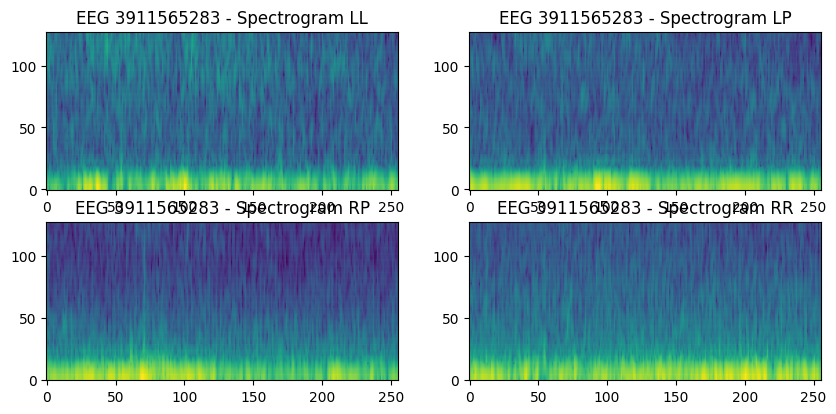

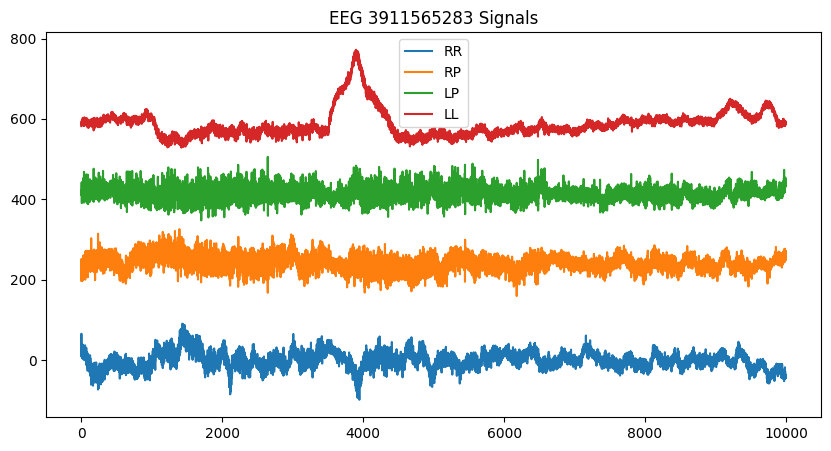


#########################



In [32]:
# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = img

In [33]:
# INFER EFFICIENTNET ON TEST
preds2 = []
test_ds = DataGenerator(test, mode='test', specs=spectrograms2, eeg_specs=all_eegs2)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=64, num_workers=3)

for i in range(5):
    print('#'*25)
    print(f'### Testing Fold {i+1}')

    ckpt_file = f'ResNet_v{VER}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/ResNet_v{VER}_f{i}.ckpt'
    model = ResNet34.load_from_checkpoint(ckpt_file)
    model.to(device).eval()
    fold_preds = []

    with torch.inference_mode():
        for test_batch in test_loader:
            test_batch = test_batch.to(device)
            pred = torch.softmax(model(test_batch), dim=1).cpu().numpy()
            fold_preds.append(pred)
        fold_preds = np.concatenate(fold_preds)

    preds2.append(fold_preds)

pred2 = np.mean(preds2,axis=0)
print()
print('Test preds shape',pred.shape)

#########################
### Testing Fold 1


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.1.3


#########################
### Testing Fold 2
#########################
### Testing Fold 3
#########################
### Testing Fold 4
#########################
### Testing Fold 5

Test preds shape (1, 6)


In [34]:
del all_eegs2, spectrograms2; gc.collect()

42052

## <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#FFFFFF'></span></b> <b>Model3 ResNet1d GRU Inference</b></div>

In [35]:
import os
import gc
import sys
import math
import time
import random
import datetime as dt
import numpy as np
import pandas as pd

from glob import glob
from pathlib import Path
from typing import Dict, List, Union
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

sys.path.append("/kaggle/input/kaggle-kl-div")
from kaggle_kl_div import score

import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

!cat /etc/os-release | grep -oP "PRETTY_NAME=\"\K([^\"]*)"
print(f"BUILD_DATE={os.environ['BUILD_DATE']}, CONTAINER_NAME={os.environ['CONTAINER_NAME']}")

try:
    print(
        f"PyTorch Version:{torch.__version__}, CUDA is available:{torch.cuda.is_available()}, Version CUDA:{torch.version.cuda}"
    )
    print(
        f"Device Capability:{torch.cuda.get_device_capability()}, {torch.cuda.get_arch_list()}"
    )
    print(
        f"CuDNN Enabled:{torch.backends.cudnn.enabled}, Version:{torch.backends.cudnn.version()}"
    )
except Exception:
    pass

Ubuntu 20.04.6 LTS
BUILD_DATE=20240123-190345, CONTAINER_NAME=tf2-gpu/2-15+cu121
PyTorch Version:2.1.2, CUDA is available:True, Version CUDA:12.1
Device Capability:(7, 5), ['sm_60', 'sm_70', 'sm_75', 'compute_70', 'compute_75']
CuDNN Enabled:True, Version:8900


In [36]:
class CFG:
    VERSION = 88

    model_name = "resnet1d_gru"

    seed = 2024
    batch_size = 32
    num_workers = 0

    fixed_kernel_size = 5
    # kernels = [3, 5, 7, 9]
    # linear_layer_features = 424
    kernels = [3, 5, 7, 9, 11]
    #linear_layer_features = 448  # Full Signal = 10_000
    #linear_layer_features = 352  # Half Signal = 5_000
    linear_layer_features = 304   # 1/5  Signal = 2_000

    seq_length = 50  # Second's
    sampling_rate = 200  # Hz
    nsamples = seq_length * sampling_rate  # Число семплов
    out_samples = nsamples // 5

    # bandpass_filter = {"low": 0.5, "high": 20, "order": 2}
    # rand_filter = {"probab": 0.1, "low": 10, "high": 20, "band": 1.0, "order": 2}
    freq_channels = []  # [(8.0, 12.0)]; [(0.5, 4.5)]
    filter_order = 2
    random_close_zone = 0.0  # 0.2
        
    target_cols = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]

    # target_preds = [x + "_pred" for x in target_cols]
    # label_to_num = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}
    # num_to_label = {v: k for k, v in label_to_num.items()}

    map_features = [
        ("Fp1", "T3"),
        ("T3", "O1"),
        ("Fp1", "C3"),
        ("C3", "O1"),
        ("Fp2", "C4"),
        ("C4", "O2"),
        ("Fp2", "T4"),
        ("T4", "O2"),
        #('Fz', 'Cz'), ('Cz', 'Pz'),        
    ]

    eeg_features = ["Fp1", "T3", "C3", "O1", "Fp2", "C4", "T4", "O2"]  # 'Fz', 'Cz', 'Pz']
        # 'F3', 'P3', 'F7', 'T5', 'Fz', 'Cz', 'Pz', 'F4', 'P4', 'F8', 'T6', 'EKG']                    
    feature_to_index = {x: y for x, y in zip(eeg_features, range(len(eeg_features)))}
    simple_features = []  # 'Fz', 'Cz', 'Pz', 'EKG'

    # eeg_features = [row for row in feature_to_index]
    # eeg_feat_size = len(eeg_features)
    
    n_map_features = len(map_features)
    in_channels = n_map_features + n_map_features * len(freq_channels) + len(simple_features)
    target_size = len(target_cols)
    
    PATH = "/kaggle/input/hms-harmful-brain-activity-classification/"
    test_eeg = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"
    test_csv = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"

In [37]:
koef_1 = 1.0
model_weights = [
    {
        'bandpass_filter':{'low':0.5, 'high':20, 'order':2}, 
        'file_data': 
        [
            #{'koef':koef_1, 'file_mask':"/kaggle/input/hms-resnet1d-gru-weights-v82/pop_1_weight_oof/*_best.pth"},
            {'koef':koef_1, 'file_mask':"/kaggle/input/hms-resnet1d-gru-weights-v82/pop_2_weight_oof/*_best.pth"},
        ]
    },
]

In [38]:
def init_logger(log_file="./test.log"):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x  # quantized


def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x


def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="band")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass_filter(
    data, cutoff_freq=20, sampling_rate=CFG.sampling_rate, order=4
):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


def denoise_filter(x):
    # Частота дискретизации и желаемые частоты среза (в Гц).
    # Отфильтруйте шумный сигнал
    y = butter_bandpass_filter(x, CFG.lowcut, CFG.highcut, CFG.sampling_rate, order=6)
    y = (y + np.roll(y, -1) + np.roll(y, -2) + np.roll(y, -3)) / 4
    y = y[0:-1:4]
    return y

In [39]:
def eeg_from_parquet(
    parquet_path: str, display: bool = False, seq_length=CFG.seq_length
) -> np.ndarray:
    """
    Эта функция читает файл паркета и извлекает средние 50 секунд показаний. Затем он заполняет значения NaN
    со средним значением (игнорируя NaN).
        :param parquet_path: путь к файлу паркета.
        :param display: отображать графики ЭЭГ или нет.
        :return data: np.array формы (time_steps, eeg_features) -> (10_000, 8)
    """

    # Вырезаем среднюю 50 секундную часть
    eeg = pd.read_parquet(parquet_path, columns=CFG.eeg_features)
    rows = len(eeg)

    # начало смещения данных, чтобы забрать середину
    offset = (rows - CFG.nsamples) // 2

    # средние 50 секунд, имеет одинаковое количество показаний слева и справа
    eeg = eeg.iloc[offset : offset + CFG.nsamples]

    if display:
        plt.figure(figsize=(10, 5))
        offset = 0

    # Конвертировать в numpy

    # создать заполнитель той же формы с нулями
    data = np.zeros((CFG.nsamples, len(CFG.eeg_features)))

    for index, feature in enumerate(CFG.eeg_features):
        x = eeg[feature].values.astype("float32")  # конвертировать в float32

        # Вычисляет среднее арифметическое вдоль указанной оси, игнорируя NaN.
        mean = np.nanmean(x)
        nan_percentage = np.isnan(x).mean()  # percentage of NaN values in feature

        # Заполнение значения Nan
        # Поэлементная проверка на NaN и возврат результата в виде логического массива.
        if nan_percentage < 1:  # если некоторые значения равны Nan, но не все
            x = np.nan_to_num(x, nan=mean)
        else:  # если все значения — Nan
            x[:] = 0
        data[:, index] = x

        if display:
            if index != 0:
                offset += x.max()
            plt.plot(range(CFG.nsamples), x - offset, label=feature)
            offset -= x.min()

    if display:
        plt.legend()
        name = parquet_path.split("/")[-1].split(".")[0]
        plt.yticks([])
        plt.title(f"EEG {name}", size=16)
        plt.show()
    return data

In [40]:
class EEGDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        batch_size: int,
        eegs: Dict[int, np.ndarray],
        mode: str = "train",
        downsample: int = None,
        bandpass_filter: Dict[str, Union[int, float]] = None,
        rand_filter: Dict[str, Union[int, float]] = None,
    ):
        self.df = df
        self.batch_size = batch_size
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        self.bandpass_filter = bandpass_filter
        self.rand_filter = rand_filter
        
    def __len__(self):
        """
        Length of dataset.
        """
        # Обозначает количество пакетов за эпоху
        return len(self.df)

    def __getitem__(self, index):
        """
        Get one item.
        """
        # Сгенерировать один пакет данных
        X, y_prob = self.__data_generation(index)
        if self.downsample is not None:
            X = X[:: self.downsample, :]
        output = {
            "eeg": torch.tensor(X, dtype=torch.float32),
            "labels": torch.tensor(y_prob, dtype=torch.float32),
        }
        return output

    def __data_generation(self, index):
        # Генерирует данные, содержащие образцы размера партии
        X = np.zeros(
            (CFG.out_samples, CFG.in_channels), dtype="float32"
        )  # Size=(10000, 14)

        row = self.df.iloc[index]  # Строка Pandas
        data = self.eegs[row.eeg_id]  # Size=(10000, 8)
        if CFG.nsamples != CFG.out_samples:
            if self.mode != "train":
                offset = (CFG.nsamples - CFG.out_samples) // 2
            else:
                #offset = random.randint(0, CFG.nsamples - CFG.out_samples)                
                offset = ((CFG.nsamples - CFG.out_samples) * random.randint(0, 1000)) // 1000
            data = data[offset:offset+CFG.out_samples,:]

        for i, (feat_a, feat_b) in enumerate(CFG.map_features):
            if self.mode == "train" and CFG.random_close_zone > 0 and random.uniform(0.0, 1.0) <= CFG.random_close_zone:
                continue
                
            diff_feat = (
                data[:, CFG.feature_to_index[feat_a]]
                - data[:, CFG.feature_to_index[feat_b]]
            )  # Size=(10000,)

            if not self.bandpass_filter is None:
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )
                    
            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, i] = diff_feat

        n = CFG.n_map_features
        if len(CFG.freq_channels) > 0:
            for i in range(CFG.n_map_features):
                diff_feat = X[:, i]
                for j, (lowcut, highcut) in enumerate(CFG.freq_channels):
                    band_feat = butter_bandpass_filter(
                        diff_feat, lowcut, highcut, CFG.sampling_rate, order=CFG.filter_order,  # 6
                    )
                    X[:, n] = band_feat
                    n += 1

        for spml_feat in CFG.simple_features:
            feat_val = data[:, CFG.feature_to_index[spml_feat]]
            
            if not self.bandpass_filter is None:
                feat_val = butter_bandpass_filter(
                    feat_val,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )

            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                feat_val = butter_bandpass_filter(
                    feat_val,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, n] = feat_val
            n += 1
            
        # Обрезать края превышающие значения [-1024, 1024]
        X = np.clip(X, -1024, 1024)

        # Замените NaN нулем и разделить все на 32
        X = np.nan_to_num(X, nan=0) / 32.0

        # обрезать полосовым фильтром верхнюю границу в 20 Hz.
        X = butter_lowpass_filter(X, order=CFG.filter_order)  # 4

        y_prob = np.zeros(CFG.target_size, dtype="float32")  # Size=(6,)
        if self.mode != "test":
            y_prob = row[CFG.target_cols].values.astype(np.float32)

        return X, y_prob

In [41]:
class ResNet_1D_Block(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        downsampling,
        dilation=1,
        groups=1,
        dropout=0.0,
    ):
        super(ResNet_1D_Block, self).__init__()

        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        # self.relu = nn.ReLU(inplace=False)
        # self.relu_1 = nn.PReLU()
        # self.relu_2 = nn.PReLU()
        self.relu_1 = nn.Hardswish()
        self.relu_2 = nn.Hardswish()

        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.conv1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.maxpool = nn.MaxPool1d(
            kernel_size=2,
            stride=2,
            padding=0,
            dilation=dilation,
        )
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu_1(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out


class EEGNet(nn.Module):
    def __init__(
        self,
        kernels,
        in_channels,
        fixed_kernel_size,
        num_classes,
        linear_layer_features,
        dilation=1,
        groups=1,
    ):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=self.planes,
                kernel_size=(kernel_size),
                stride=1,
                padding=0,
                dilation=dilation,
                groups=groups,
                bias=False,
            )
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        # self.relu = nn.ReLU(inplace=False)
        # self.relu_1 = nn.ReLU()
        # self.relu_2 = nn.ReLU()
        self.relu_1 = nn.SiLU()
        self.relu_2 = nn.SiLU()

        self.conv1 = nn.Conv1d(
            in_channels=self.planes,
            out_channels=self.planes,
            kernel_size=fixed_kernel_size,
            stride=2,
            padding=2,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.block = self._make_resnet_layer(
            kernel_size=fixed_kernel_size,
            stride=1,
            dilation=dilation,
            groups=groups,
            padding=fixed_kernel_size // 2,
        )
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)

        self.rnn = nn.GRU(
            input_size=self.in_channels,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            # dropout=0.2,
        )

        self.fc = nn.Linear(in_features=linear_layer_features, out_features=num_classes)

    def _make_resnet_layer(
        self,
        kernel_size,
        stride,
        dilation=1,
        groups=1,
        blocks=9,
        padding=0,
        dropout=0.0,
    ):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
            )
            layers.append(
                ResNet_1D_Block(
                    in_channels=self.planes,
                    out_channels=self.planes,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    downsampling=downsampling,
                    dilation=dilation,
                    groups=groups,
                    dropout=dropout,
                )
            )
        return nn.Sequential(*layers)

    def extract_features(self, x):
        x = x.permute(0, 2, 1)
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu_1(out)
        out = self.conv1(out)

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]  # <~~

        new_out = torch.cat([out, new_rnn_h], dim=1)
        return new_out

    def forward(self, x):
        new_out = self.extract_features(x)
        result = self.fc(new_out)
        return result

In [42]:
def inference_function(test_loader, model, device):
    model.eval()  # set model in evaluation mode
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc="Inference") as tqdm_test_loader:
        for step, batch in enumerate(tqdm_test_loader):
            X = batch.pop("eeg").to(device)  # send inputs to `device`
            batch_size = X.size(0)
            with torch.no_grad():
                y_preds = model(X)  # forward propagation pass
            y_preds = softmax(y_preds)
            preds.append(y_preds.to("cpu").numpy())  # save predictions

    prediction_dict["predictions"] = np.concatenate(
        preds
    )  # np.array() of shape (fold_size, target_cols)
    return prediction_dict

In [43]:
test_df = pd.read_csv(CFG.test_csv)
print(f"Test dataframe shape is: {test_df.shape}")
test_df.head()

Test dataframe shape is: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [44]:
test_eeg_parquet_paths = glob(CFG.test_eeg + "*.parquet")
test_eeg_df = pd.read_parquet(test_eeg_parquet_paths[0])
test_eeg_features = test_eeg_df.columns
print(f"There are {len(test_eeg_features)} raw eeg features")
print(list(test_eeg_features))
del test_eeg_df
_ = gc.collect()

# %%time
all_eegs = {}
eeg_ids = test_df.eeg_id.unique()
for i, eeg_id in tqdm(enumerate(eeg_ids)):
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = CFG.test_eeg + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path)
    all_eegs[eeg_id] = data

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


0it [00:00, ?it/s]

In [45]:
koef_sum = 0
koef_count = 0
predictions = []
files = []
    
for model_block in model_weights:
    test_dataset = EEGDataset(
        df=test_df,
        batch_size=CFG.batch_size,
        mode="test",
        eegs=all_eegs,
        bandpass_filter=model_block['bandpass_filter']
    )

    if len(predictions) == 0:
        output = test_dataset[0]
        X = output["eeg"]
        print(f"X shape: {X.shape}")
                
    test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )

    for file_line in model_block['file_data']:
        koef = file_line['koef']
        for weight_model_file in glob(file_line['file_mask']):
            files.append(weight_model_file)
            checkpoint = torch.load(weight_model_file, map_location=device)
            model.load_state_dict(checkpoint["model"])
            model.to(device)
            prediction_dict = inference_function(test_loader, model, device)
            predict = prediction_dict["predictions"]
            predict *= koef
            koef_sum += koef
            koef_count += 1
            predictions.append(predict)
            torch.cuda.empty_cache()
            gc.collect()

predictions = np.array(predictions)
koef_sum /= koef_count
predictions /= koef_sum
predictions = np.mean(predictions, axis=0)

X shape: torch.Size([2000, 8])


Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

Inference:   0%|          | 0/1 [00:00<?, ?test_batch/s]

In [46]:
sub = pd.DataFrame({"eeg_id": test_df.eeg_id.values})
# predictions: resnet 1d, pred: 10m&50s, pred2: resnet34
sub[CFG.target_cols] = predictions * 0.4 + pred * 0.4 + pred * 0.2

sub.to_csv(f"submission.csv", index=False)
print(f"Submission shape: {sub.shape}")
sub.head()

Submission shape: (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.1721,0.048233,0.005052,0.11278,0.07661,0.585225


In [47]:
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32